# Histopathologic Cancer Detection with a Convolutional Neural Network

The goal of this project is to create a CNN model capable of predicting the presence of cancer in image patches taken from larger digital pathology scans. For a given image, a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

The dataset for this project consists of 220,025 training images and 57,458 testing images, located in independent "train" and "test" folders. All images have a (96,96) size (9,216 pixels per image) and are stored in the Tag Image File Format (TIFF). 

A list of labels for the training dataset is stored as a CSV file outside of either directory, and it consists of two colums:
* <b>id</b> - This is a unique identifier that corresponds to a given image's filename.
* <b>label</b> - A binary value that indicates if image center contains a tumor. 

## Setup

In [71]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Exploratory Data Analysis

First, we begin by observing what is the distribution of class samples within the training dataset.

In [69]:
training_labels = pd.read_csv('./Data/train_labels.csv')
training_labels = training_labels.sort_values('id', ascending=True)

counts = training_labels["label"].value_counts()
indexes = [index for index, _ in counts.items()]
percentages = [ round(value / sum(counts), 5)*100 for _, value in counts.items() ]

data_distibution = pd.DataFrame({"Amount": counts.to_list(), "Percentage": percentages}, index=indexes)
data_distibution

,Amount,Percentage
0,130908,59.497
1,89117,40.503


We can observe that the training dataset has a raoughly even split between both classes. While there are more "false" samples the skew is not so large as to require a dataset re-balancing during model creation and training. Furthermore, the large amount of samples within each group will compensate for the imperfect split.

Below we can better visualize the trainiing dataset distribution with a histogram.

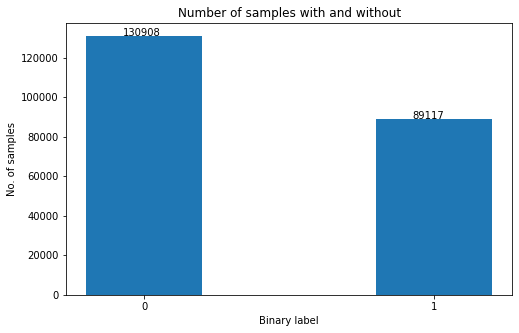

In [51]:
# creating the dataset
data = counts
topics = list(data.axes[0])
topics = [str(item) for item in topics]
values = list(data.values)
  
fig = plt.figure(figsize = (8, 5))
plt.bar(topics, values, width = 0.4)

for i in range(len(values)):
        plt.text( i-0.075, values[i]+2, values[i])

plt.xlabel("Binary label")
plt.ylabel("No. of samples")
plt.title("Number of samples with and without")
plt.show()

To obtain a better idea of how the samples ar composed, we can randomly open an image and observe its composition. The most important values to confirm are the image size (width, height) as well as its depth and whether the image is monochromatic, RGB, CMYK or some other format.

width:  96
height: 96


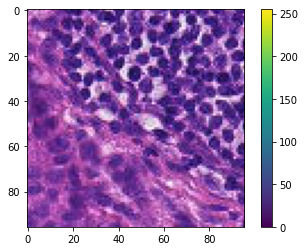

In [92]:
from PIL import Image

im = Image.open('./Data/train/000a2a35668f04edebc0b06d5d133ad90c93a044.tif')
w, h = im.size
print('width: ', w)
print('height:', h)

plt.imshow(im)
plt.colorbar()


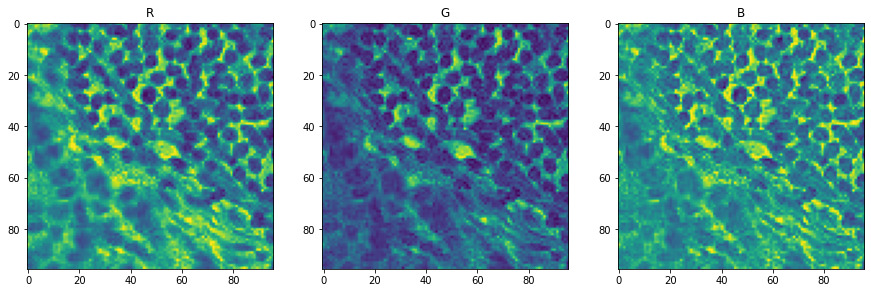

In [98]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))
band_values = []

for i in range(len(bands)):
    band_values.append(im.getchannel(bands[i]))
    axarr[i].imshow(band_values[i])
    axarr[i].title.set_text(bands[i])

As we can see in the plots above, the images are coded in the RGB format, for a resulting depth of 3 on input arrays. Furthermore, the data contained in each channel within is different from one another, cofirming the images are truly RGB and not a monochromatic image copied three times.

To get a better idea of how color dispersion, we can plot a histogram for the pixel values across each channel.

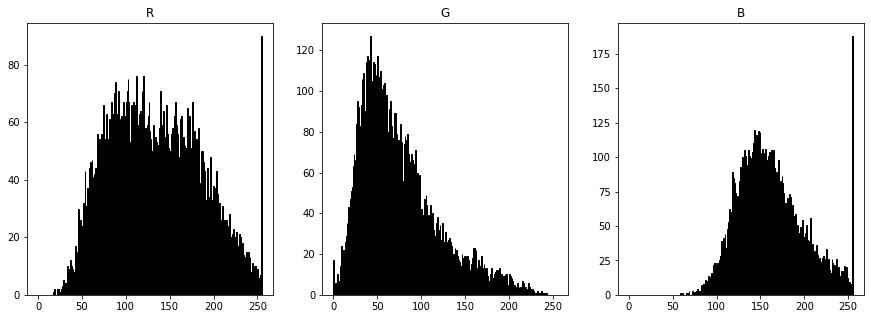

In [81]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))
band_values = []

for i in range(len(bands)):
    band_values.append(im.getchannel(bands[i]))
    axarr[i].imshow(band_values[i])
    axarr[i].title.set_text(bands[i])


The Red and Blue channels appear to be normally distributed, while the Green channel has a right-skewed distribution.

For further analysis, we will repeat the previous process with another random image and observe the histrogram results. 

width:  96
height: 96


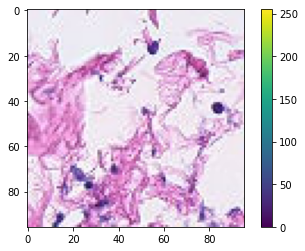

In [85]:
from PIL import Image

im = Image.open('./Data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
w, h = im.size
print('width: ', w)
print('height:', h)

plt.imshow(im)
plt.colorbar()


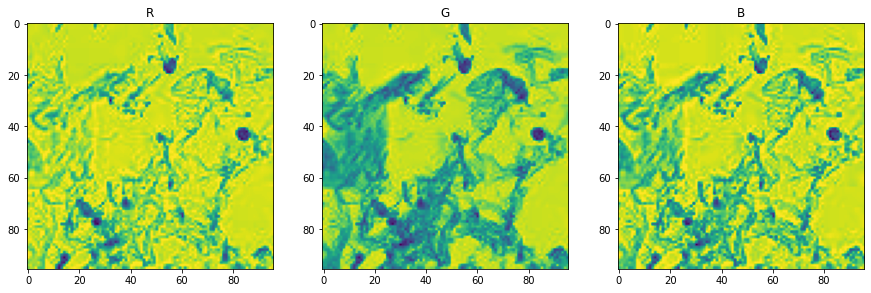

In [86]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))
band_values = []

for i in range(len(bands)):
    band_values.append(im.getchannel(bands[i]))
    axarr[i].imshow(band_values[i])
    axarr[i].title.set_text(bands[i])


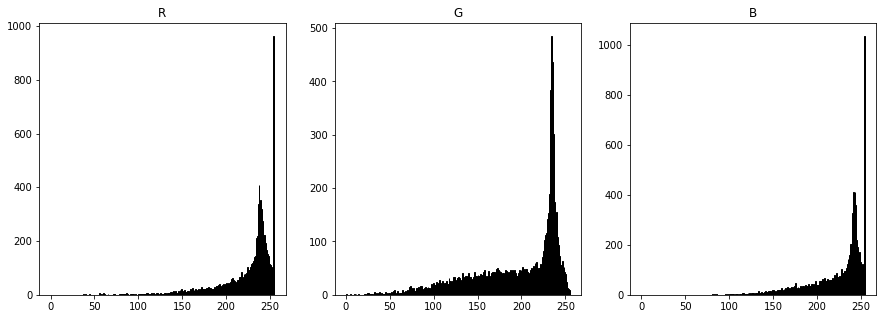

In [87]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))

for i in range(len(band_values)):
    axarr[i].title.set_text(bands[i])
    axarr[i].hist(np.ravel(band_values[i]), bins=range(256), fc='k', ec='k')

On this image, all three channels are heavily left-skewed in their pixel values. 

From this we can conclude there are two possible pre-processing paths to take:
* We could leave all images as they are and submit them to the CNN without any pre-processing
* We could apply dynamic range techniques to each image before submitting it to the model. This would normalize the inputs to the model, but some information may be lost.

For starters, we will leave the images untouched and review the need for pre-processing after obtaining the first model's results.

## Model Architecture

### Model Selection

-- TODO

### First Model Construction

-- TODO


### Second Model Construction

-- TODO

### Hyper-parameter tuning

-- TODO

## Results

### Model comparison results

-- TODO

### Hyper-parameter optimization results

-- TODO

### Useful training techniques

-- TODO

## Conclusions

### Learnings

-- TODO

### Future works

-- TODO

## References

* [Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle.](https://kaggle.com/competitions/histopathologic-cancer-detection)